In [1]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image

In [2]:
train_dir = 'split/train'
train_CORROSION_dir = 'split/train/CORROSION/'
train_NOCORROSION_dir = 'split/train/NOCORROSION/'

validation_dir = 'split/validation'
validation_CORROSION_dir = 'split/validation/CORROSION/'
validation_NOCORROSION_dir = 'split/validation/NOCORROSION/'

test_dir = 'split/test'
test_CORROSION_dir = 'split/test/CORROSION/'
test_NOCORROSION_dir = 'split/test/NOCORROSION/'

In [3]:
def num_files_in_direcotry(path):
    num = len([file for file in os.listdir(path) if file.endswith('.jpg')])
    return num

# Function for results visualization

In [4]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history['acc']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [5]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (128,128),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42
                                         )
        generator_lst.append(g)
    
    return generator_lst

In [6]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [7]:
 # Design the model
    
def build_model_1():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    

    cnn.add(Flatten())

    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn = build_model_1()

In [8]:
# Train the model
cnn_model = cnn.fit_generator(train_generator,
                              epochs = 20,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_24940\3807750235.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = cnn.fit_generator(train_generator,


Epoch 1/20
40/40 [==============================] - 75s 2s/step - loss: 0.6794 - acc: 0.5365 - val_loss: 0.6413 - val_acc: 0.6676
Epoch 2/20
40/40 [==============================] - 66s 2s/step - loss: 0.6053 - acc: 0.6936 - val_loss: 0.5775 - val_acc: 0.7500
Epoch 3/20
40/40 [==============================] - 58s 1s/step - loss: 0.5986 - acc: 0.6999 - val_loss: 0.5962 - val_acc: 0.7308
Epoch 4/20
40/40 [==============================] - 57s 1s/step - loss: 0.6007 - acc: 0.7038 - val_loss: 0.6036 - val_acc: 0.6978
Epoch 5/20
40/40 [==============================] - 61s 2s/step - loss: 0.5826 - acc: 0.6944 - val_loss: 0.7534 - val_acc: 0.6511
Epoch 6/20
40/40 [==============================] - 57s 1s/step - loss: 0.6137 - acc: 0.6921 - val_loss: 0.5649 - val_acc: 0.7665
Epoch 7/20
40/40 [==============================] - 62s 2s/step - loss: 0.5400 - acc: 0.7463 - val_loss: 0.5209 - val_acc: 0.7610
Epoch 8/20
40/40 [==============================] - 60s 1s/step - loss: 0.4896 - acc: 0.78

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_24940\2413494331.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 79.67% | Precision = 77.68% | Recall = 87.88% | Specificity = 69.88% | F1 Score = 82.46%


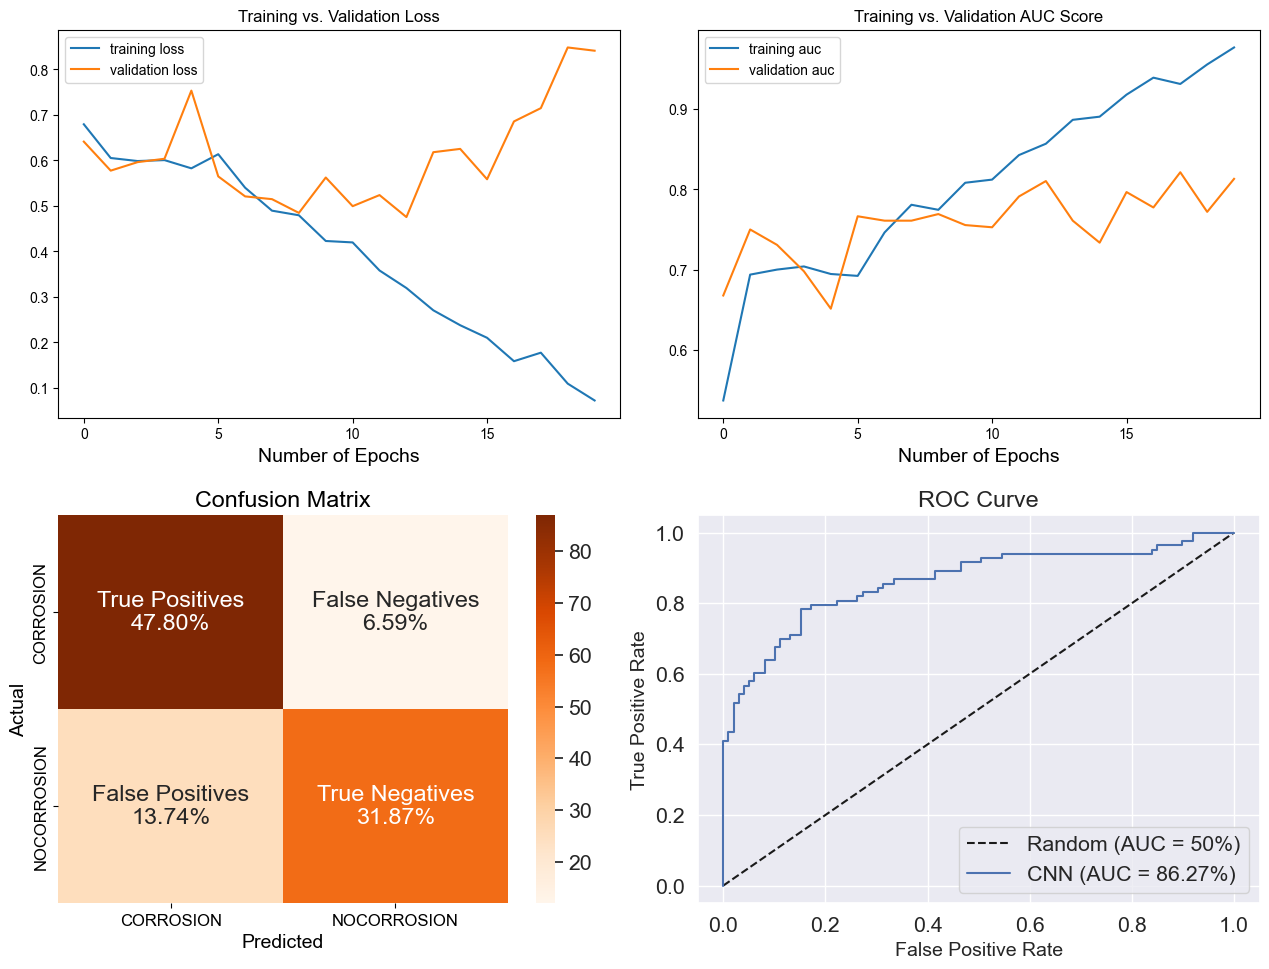

In [9]:
create_charts(cnn,cnn_model)

In [32]:
cnn.save('model/cnn_model.h5')

D:\Program Files\anaconda3\envs\corrosion\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
load_model = keras.models.load_model("model/cnn_model.h5")


In [58]:
def view(path):
    plt.imshow(Image.open(img_path))

In [59]:
def predict(path):
    view(path)
    img = image.load_img(img_path, target_size=(128, 128))  # Target size should match the input size of your model
    img = image.img_to_array(img)
    img = img / 255.0  # Rescale the pixel values to [0, 1] if you didn't do it during training
    img = np.expand_dims(img, axis=0)
    predictions = load_model.predict(img)
    threshold = 0.5
    # Convert probabilities to class labels
    classes = ['CORROSION','NOCORROSION']
    predicted_class = 1 if predictions[0] > threshold else 0
    print("The given image is a",classes[predicted_class],'class Image')

1/1 [==============================] - 0s 48ms/step
The given image is a NOCORROSION class Image


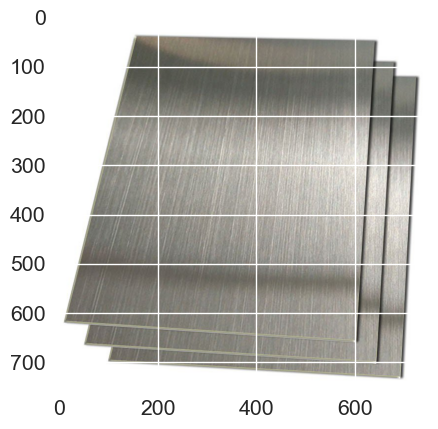

In [60]:
img_path = "split/test/NOCORROSION/f2a1390619.jpg"  
predict(img_path)

1/1 [==============================] - 0s 32ms/step
The given image is a CORROSION class Image


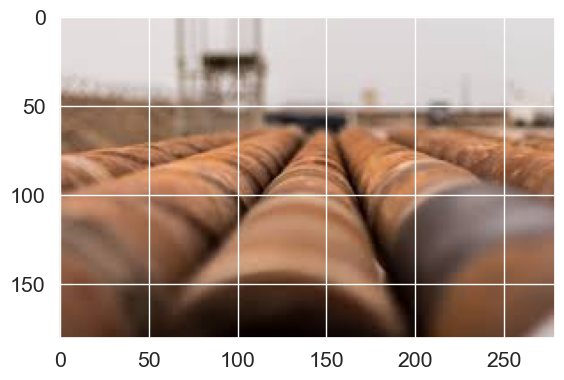

In [61]:
img_path = "split/test/CORROSION/f91b94841a.jpg"  # Replace with the actual image file path
predict(img_path)